In [1]:
import os 
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import time
import random
from pprint import pprint
from glob import glob
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2
from matplotlib.patches import FancyArrowPatch

import pyrender

import pygarment as pyg
import trimesh
import PIL
from PIL import Image

from analysis_utils import visualize_meshes_plotly, v_id_map, plot_panel_info

DATASET_ROOT_PATH = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/"
GARMENT_ROOT_PATH = os.path.join(DATASET_ROOT_PATH, "GarmentCodeData_v2")
BODY_ROOT_PATH = os.path.join(DATASET_ROOT_PATH, "body_mesh")
MEAN_ALL_BODY_PATH = os.path.join(DATASET_ROOT_PATH, "neutral_body/mean_all.obj")

default_body_mesh = trimesh.load(MEAN_ALL_BODY_PATH)

print("body vertices", default_body_mesh.vertices.shape)
print("body faces", default_body_mesh.faces.shape)

# BODY_TYPE = "random_body"
BODY_TYPE = "default_body"

def fff(garment_path) :
    garment_id = os.path.basename(garment_path)
    if os.path.exists(
        os.path.join(garment_path, f"{garment_id}_fltrd_vis_seam_line_dict.pkl")
    ) and os.path.exists(
        os.path.join(garment_path, f"rendered_front.png")
    ):
        return True
    else :
        return False

garment_path_list = list(filter(
    fff,
    sorted(list(filter(
        os.path.isdir,
        glob(os.path.join(GARMENT_ROOT_PATH, "*", BODY_TYPE, "*"))
    )))
))

body vertices (23751, 3)
body faces (47500, 3)


In [263]:
for seam_idx, seam_dict in fltrd_vis_seam_line_dict["front"].items() :
    for segment_idx, (
        segment_pos_arr, segment_t_arr,
        segment_u_arr, segment_v_arr
    ) in enumerate(zip(
        seam_dict["segment_pos_arr_list"],
        seam_dict["segment_t_arr_list"],
        seam_dict["segment_u_arr_list"],
        seam_dict["segment_v_arr_list"]
    )) :
        if len(segment_pos_arr) < 1 :
            print(segment_pos_arr.shape)
            print(segment_t_arr.shape)
            print(segment_u_arr.shape)
            print(segment_v_arr.shape)
            print()


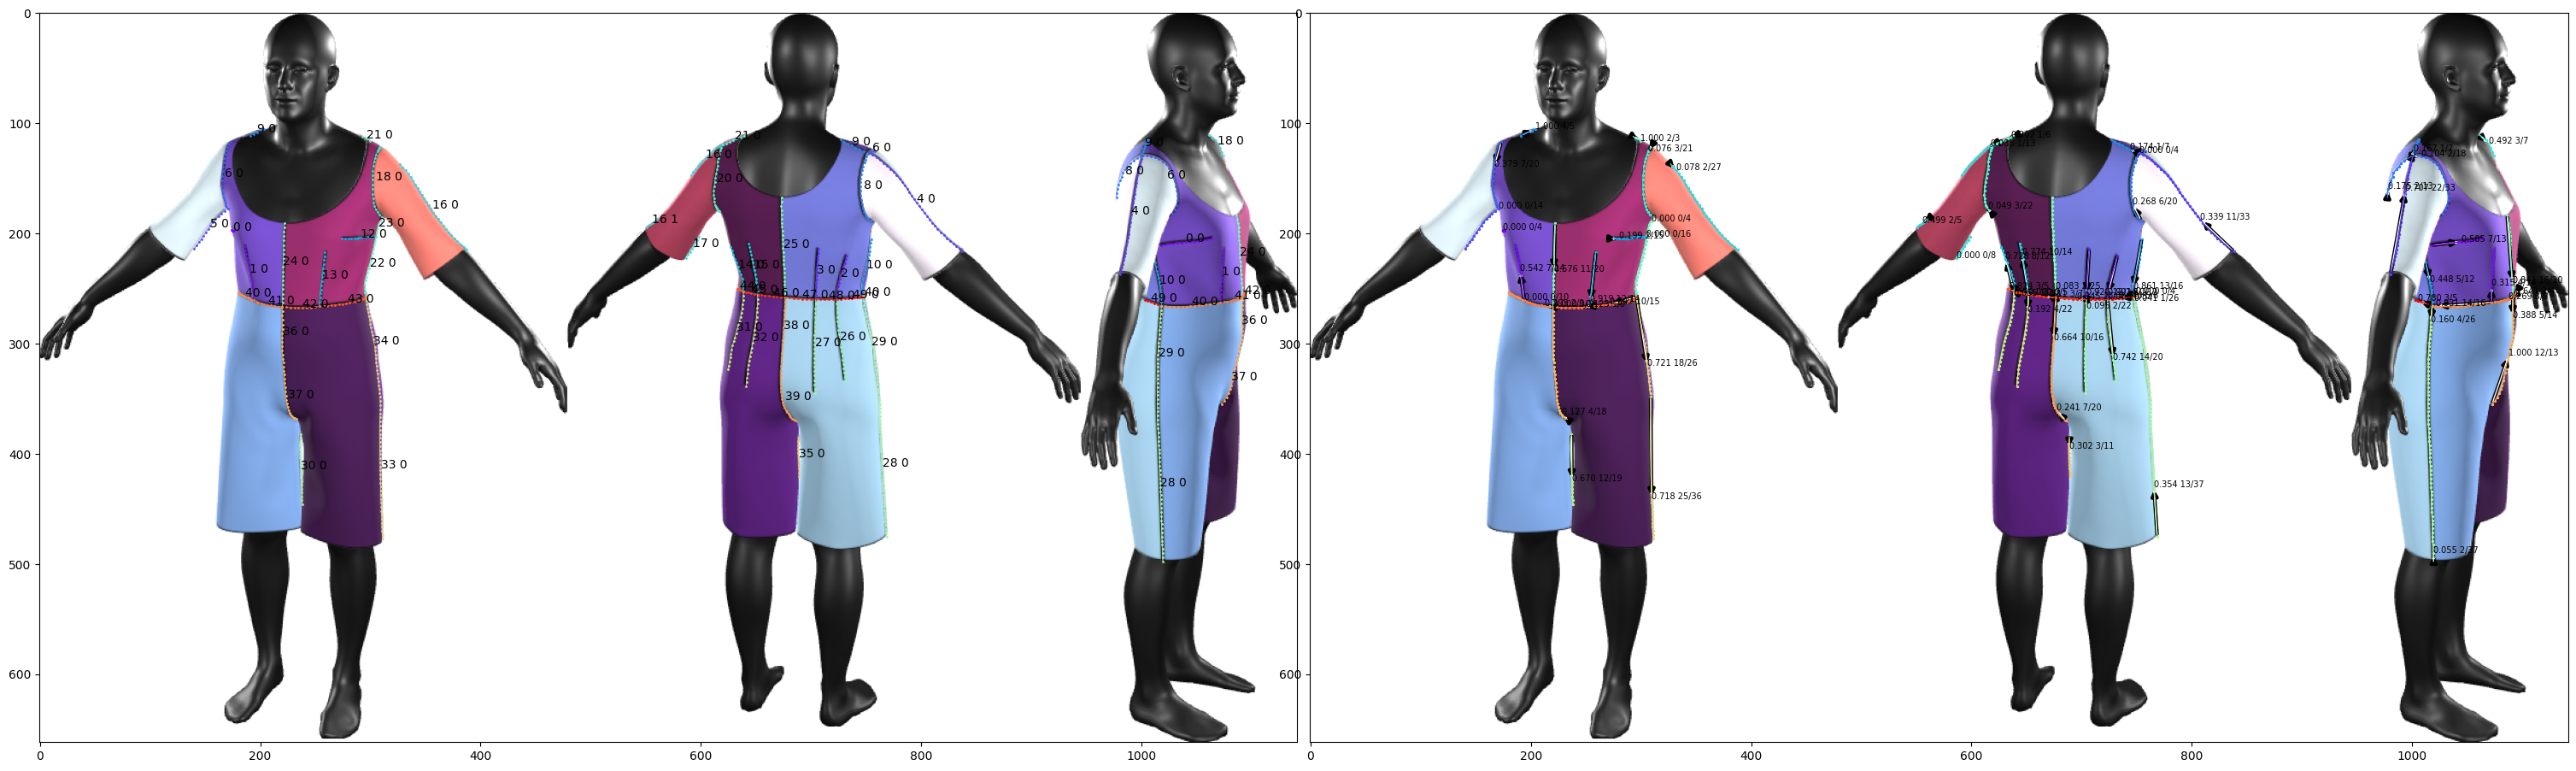

{'front': {0: {'raw_idx_arr': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'raw_vis_mask': array([False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True]), 'segment_idx_arr_list': [array([11, 12, 13, 14])], 'segment_pos_arr_list': [array([[174.21521417, 196.89460779],
       [174.63265711, 197.19054019],
       [175.38355624, 197.49035065],
       [176.46460161, 197.69960073]])], 'segment_edge_len_arr_list': [array([0.        , 0.51169776, 0.8085393 , 1.10111066])], 'segment_t_arr_list': [array([0.        , 0.21132766, 0.54524885, 1.        ])], 'segment_u_arr_list': [array([0.        , 0.20624815, 0.54445599, 1.        ])], 'segment_v_arr_list': [array([ 0.        , -0.05775088, -0.07000111,  0.        ])]}, 1: {'raw_idx_arr': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), 'raw_vis_mask': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  Tr

In [322]:
from copy import deepcopy
from matplotlib.patches import FancyArrowPatch


IDX = random.randint(0, len(garment_path_list) - 1)

garment_path = garment_path_list[IDX]
garment_id = os.path.basename(garment_path)

rendered_image_dict = {}
for side in ["front", "back", "left", "right"] :
    rendered_image_dict[side] = Image.open(os.path.join(garment_path, f"rendered_{side}.png"))
with open(os.path.join(garment_path, f"{garment_id}_fltrd_vis_seam_line_dict.pkl"), "rb") as f :
    fltrd_vis_seam_line_dict = pickle.load(f)

with open(os.path.join(garment_path, f"{garment_id}_projected_vertex_pose.pkl"), "rb") as f :
    projected_vertex_pose_dict = pickle.load(f)

with open(os.path.join(garment_path, f"{garment_id}_vertex_visibility_mask.pkl"), "rb") as f :
    vertex_visibility_mask_dict = pickle.load(f)

side_list = random.sample(
    ["front", "back", "left", "right"],
    random.randint(1, 4)
)   


if len(side_list) == 1 :
    img_arr = np.array(rendered_image_dict[side_list[0]].convert('RGB'))
    IMG_H, IMG_W = img_arr.shape[:2]
    mask = (img_arr != 255).any(axis=2)
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    y1, y2 = np.where(rows)[0][[0, -1]]
    x1, x2 = np.where(cols)[0][[0, -1]]

    margin_t = random.randint(0, y1)
    margin_b = random.randint(y2, IMG_H - 1)
    margin_l = random.randint(0, x1)
    margin_r = random.randint(x2, IMG_W - 1)

    final_img = img_arr[
        margin_t:margin_b, margin_l:margin_r
    ].copy()

    annotation_dict = {side_list[0]: {}}
    for seam_idx, seam_dict in fltrd_vis_seam_line_dict[side_list[0]].items() :
        annotation_dict[side_list[0]][seam_idx] = deepcopy(seam_dict)
        for segment_pos_arr in annotation_dict[side_list[0]][seam_idx]["segment_pos_arr_list"] :
            segment_pos_arr[:, 0] -= margin_l
            segment_pos_arr[:, 1] -= margin_t
    
elif len(side_list) in [2, 3] :
    x1_list = []
    y1_list = []
    bb_w_list = []
    bb_h_list = []
    img_patch_list = []
    for side_idx, side in enumerate(side_list) :        
        img_arr = np.array(rendered_image_dict[side].convert('RGB'))
        mask = (img_arr != 255).any(axis=2)
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)

        y1, y2 = np.where(rows)[0][[0, -1]]
        x1, x2 = np.where(cols)[0][[0, -1]]

        x1_list.append(x1)
        y1_list.append(y1)
        bb_w_list.append(x2 - x1)
        bb_h_list.append(y2 - y1)
        
        img_patch_list.append(
            img_arr[y1:y2, x1:x2].copy()
        )
    
    final_img = np.ones(
        (np.max(bb_h_list), np.sum(bb_w_list), 3),
        dtype=np.uint8
    ) * 255
    
    bb_h_max = np.max(bb_h_list)
    
    annotation_dict = {side: {} for side in side_list}
    x_pos = 0
    for (side, img_patch, x1, y1, bb_w, bb_h) in zip(
        side_list, img_patch_list, x1_list, y1_list, bb_w_list, bb_h_list
    ) :
        y_margin_t = random.randint(0, bb_h_max - bb_h)    
        final_img[
            y_margin_t:y_margin_t + bb_h, x_pos:x_pos + bb_w
        ] = img_patch
    
        for seam_idx, seam_dict in fltrd_vis_seam_line_dict[side].items() :
            annotation_dict[side][seam_idx] = deepcopy(seam_dict)
            for segment_pos_arr in annotation_dict[side][seam_idx]["segment_pos_arr_list"] :
                segment_pos_arr[:, 0] = segment_pos_arr[:, 0] - x1 + x_pos
                segment_pos_arr[:, 1] = segment_pos_arr[:, 1] - y1 + y_margin_t
    
        x_pos += bb_w
        
elif len(side_list) == 4 :    
    final_side_list = [side_list[0]]
    if final_side_list[0] in ["front", "back"] :
        final_side_list.append(random.choice(["left", "right"]))
    else :
        final_side_list.append(random.choice(["front", "back"]))
    remaining_side_list = list(set(side_list) - set(final_side_list))

    while len(remaining_side_list) > 0 :
        final_side_list.append(remaining_side_list.pop(0))

    x1_list = []
    y1_list = []
    bb_w_list = []
    bb_h_list = []
    img_patch_list = []
    for side_idx, side in enumerate(final_side_list) :        
        img_arr = np.array(rendered_image_dict[side].convert('RGB'))
        mask = (img_arr != 255).any(axis=2)
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)

        y1, y2 = np.where(rows)[0][[0, -1]]
        x1, x2 = np.where(cols)[0][[0, -1]]

        x1_list.append(x1)
        y1_list.append(y1)
        bb_w_list.append(x2 - x1)
        bb_h_list.append(y2 - y1)
        
        img_patch_list.append(
            img_arr[y1:y2, x1:x2].copy()
        )

    row1_h_max = max(bb_h_list[0], bb_h_list[1])
    row1_w = bb_w_list[0] + bb_w_list[1]
    row2_h_max = max(bb_h_list[2], bb_h_list[3])
    row2_w = bb_w_list[2] + bb_w_list[3]

    final_img = np.ones(
        (
            row1_h_max + row2_h_max,
            max(row1_w, row2_w),
            3
        ),
        dtype=np.uint8
    ) * 255
    
    annotation_dict = {side: {} for side in final_side_list}
    x_pos = 0
    for side, img_patch, x1, y1, bb_h, bb_w in zip(
        final_side_list[:2], img_patch_list[:2], x1_list[:2], y1_list[:2], bb_h_list[:2], bb_w_list[:2]
    ) :
        margin_t = random.randint(0, row1_h_max - bb_h)
        final_img[
            margin_t:margin_t + bb_h,
            x_pos:x_pos + bb_w,
        ] = img_patch
        
        for seam_idx, seam_dict in fltrd_vis_seam_line_dict[side].items() :
            annotation_dict[side][seam_idx] = deepcopy(seam_dict)
            for segment_pos_arr in annotation_dict[side][seam_idx]["segment_pos_arr_list"] :
                segment_pos_arr[:, 0] = segment_pos_arr[:, 0] - x1 + x_pos
                segment_pos_arr[:, 1] = segment_pos_arr[:, 1] - y1 + margin_t
        
        x_pos += bb_w
        
    x_pos = 0
    for side, img_patch, x1, y1, bb_h, bb_w in zip(
        final_side_list[2:], img_patch_list[2:], x1_list[2:], y1_list[2:], bb_h_list[2:], bb_w_list[2:]
    ) :
        margin_t = random.randint(0, row2_h_max - bb_h)
        final_img[
            row1_h_max + margin_t:row1_h_max + margin_t + bb_h,
            x_pos:x_pos + bb_w,
        ] = img_patch

        for seam_idx, seam_dict in fltrd_vis_seam_line_dict[side].items() :
            annotation_dict[side][seam_idx] = deepcopy(seam_dict)
            for segment_pos_arr in annotation_dict[side][seam_idx]["segment_pos_arr_list"] :
                segment_pos_arr[:, 0] = segment_pos_arr[:, 0] - x1 + x_pos
                segment_pos_arr[:, 1] = segment_pos_arr[:, 1] - y1 + margin_t + row1_h_max

        x_pos += bb_w

FIGLEN = 15
NROWS = 3
NCOLS = len(vertex_visibility_mask_dict.keys())
plt.figure(figsize=(NCOLS * FIGLEN, NROWS * FIGLEN))

ax1 = plt.subplot(NROWS, NCOLS, 1)
ax1.imshow(final_img)
plt.tight_layout()

ax2 = plt.subplot(NROWS, NCOLS, 2)
ax2.imshow(final_img)

STCH_IDX_MAX = max(list(map(
    lambda stch_dict : max(stch_dict.keys()),
    annotation_dict.values()
)))
colors = plt.cm.rainbow(np.linspace(0, 1, STCH_IDX_MAX + 1))

for side, seam_dict in annotation_dict.items() :
    for seam_idx, seam_dict in seam_dict.items() :
        for segment_idx, (
            segment_pos_arr, segment_t_arr,
            segment_u_arr, segment_v_arr
        ) in enumerate(zip(
            seam_dict["segment_pos_arr_list"],
            seam_dict["segment_t_arr_list"],
            seam_dict["segment_u_arr_list"],
            seam_dict["segment_v_arr_list"]
        )) :
            ax1.plot(
                segment_pos_arr[:, 0],
                segment_pos_arr[:, 1],
                '-',
                color=colors[seam_idx],
                linewidth=0.5
            )
            ax1.scatter(
                segment_pos_arr[:, 0],
                segment_pos_arr[:, 1],
                color=colors[seam_idx],
                s=1
            )
            
            ax1.annotate(
                f"{seam_idx} {segment_idx}",
                segment_pos_arr.mean(axis=0),
                fontsize=10
            )
            
            ax2.plot(
                segment_pos_arr[:, 0],
                segment_pos_arr[:, 1],
                '-',
                color=colors[seam_idx],
                linewidth=1
            )
            ax2.scatter(
                segment_pos_arr[:, 0],
                segment_pos_arr[:, 1],
                color=colors[seam_idx],
                s=2
            )
            
            i_vec = segment_pos_arr[-1] - segment_pos_arr[0]
            j_vec = np.array([i_vec[1], -i_vec[0]])
            random_idx = random.randint(0, len(segment_pos_arr) - 1)
            t = segment_t_arr[random_idx]
            u = segment_u_arr[random_idx]
            v = segment_v_arr[random_idx]
            
            if np.sum(segment_pos_arr[0] + u*i_vec + v*j_vec - segment_pos_arr[random_idx]) > 1e-5 :
                print("error")
                print(side, seam_idx, segment_idx)
            
            ax2.annotate(
                f"{t:.3f} {random_idx}/{len(segment_pos_arr)}",
                segment_pos_arr[random_idx],
                fontsize=7
            )
            ax2.add_patch(
                FancyArrowPatch(
                    segment_pos_arr[0],
                    segment_pos_arr[0] + u * i_vec + v * j_vec,
                    arrowstyle='-|>',
                    color="black",
                    mutation_scale=10,
                    linewidth=3
                )
            )
            ax2.add_patch(               
                FancyArrowPatch(
                    segment_pos_arr[0],
                    segment_pos_arr[random_idx],
                    arrowstyle='-|>',
                    color="white",
                    mutation_scale=4,
                    linewidth=1
                )
            )
            
            
plt.show()

In [317]:
segment_pos_arr[0] + u*i_vec + v*j_vec, segment_pos_arr[random_idx]

(array([281.57147144, 476.86830649]), array([281.57147144, 476.86830649]))

In [283]:
annotation_dict

{'right': {},
 'back': {},
 'left': {},
 'front': {0: {'raw_idx_arr': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
   'raw_vis_mask': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True, False, False]),
   'segment_idx_arr_list': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])],
   'segment_pos_arr_list': [array([[957.00437585, 203.11157034],
           [959.89597731, 203.49856324],
           [962.77977031, 203.83491268],
           [965.71924465, 204.21992854],
           [968.15884903, 204.37204303],
           [970.43558944, 204.4921649 ],
           [972.71036366, 204.66034698],
           [974.9285042 , 204.80700615],
           [976.93815979, 204.8808177 ],
           [978.99006495, 205.02617987],
           [980.09513126, 205.12340108],
           [981.06183221, 205.34132798],
           [982.60568916, 205.36740613]])],
   'segment_edge_len_arr_list': [array([0.        , 2.91738282, 2.90

In [254]:
_ = """
IDX = random.randint(0, len(garment_path_list) - 1)

garment_path = garment_path_list[IDX]
garment_id = os.path.basename(garment_path)

rendered_image_dict = {}
for side in ["front", "back", "left", "right"] :
    rendered_image_dict[side] = Image.open(os.path.join(garment_path, f"rendered_{side}.png"))
with open(os.path.join(garment_path, f"{garment_id}_fltrd_vis_seam_line_dict.pkl"), "rb") as f :
    fltrd_vis_seam_line_dict = pickle.load(f)

with open(os.path.join(garment_path, f"{garment_id}_projected_vertex_pose.pkl"), "rb") as f :
    projected_vertex_pose_dict = pickle.load(f)

with open(os.path.join(garment_path, f"{garment_id}_vertex_visibility_mask.pkl"), "rb") as f :
    vertex_visibility_mask_dict = pickle.load(f)

side_list = random.sample(
    ["front", "back", "left", "right"],
    random.randint(1, 4)
)

if len(side_list) == 1 :
    img_arr = np.array(rendered_image_dict[side_list[0]].convert('RGB'))
    IMG_H, IMG_W = img_arr.shape[:2]
    mask = (img_arr != 255).any(axis=2)
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    y1, y2 = np.where(rows)[0][[0, -1]]
    x1, x2 = np.where(cols)[0][[0, -1]]

    margin_t = random.randint(0, y1)
    margin_b = random.randint(y2, IMG_H - 1)
    margin_l = random.randint(0, x1)
    margin_r = random.randint(x2, IMG_W - 1)

    final_img = img_arr[
        margin_t:margin_b, margin_l:margin_r
    ].copy()
    
elif len(side_list) in [2, 3] :
    x1_list = []
    y1_list = []
    bb_w_list = []
    bb_h_list = []
    img_patch_list = []
    for side_idx, side in enumerate(side_list) :        
        img_arr = np.array(rendered_image_dict[side].convert('RGB'))
        mask = (img_arr != 255).any(axis=2)
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)

        y1, y2 = np.where(rows)[0][[0, -1]]
        x1, x2 = np.where(cols)[0][[0, -1]]

        x1_list.append(x1)
        y1_list.append(y1)
        bb_w_list.append(x2 - x1)
        bb_h_list.append(y2 - y1)
        
        img_patch_list.append(
            img_arr[y1:y2, x1:x2].copy()
        )
    
    final_img = np.ones(
        (np.max(bb_h_list), np.sum(bb_w_list), 3),
        dtype=np.uint8
    ) * 255
    
    bb_h_max = np.max(bb_h_list)
    
    x_pos = 0
    for img_patch, (
        x1, y1, bb_w, bb_h
    ) in zip(img_patch_list, zip(x1_list, y1_list, bb_w_list, bb_h_list)) :
        y_margin_t = random.randint(0, bb_h_max - bb_h)
        # y_margin_b = bb_h_max - bb_h - y_margin_t
        final_img[
            y_margin_t:y_margin_t + bb_h, x_pos:x_pos + bb_w
        ] = img_patch
        x_pos += bb_w
    
elif len(side_list) == 4 :    
    final_side_list = [side_list[0]]
    if final_side_list[0] in ["front", "back"] :
        final_side_list.append(random.choice(["left", "right"]))
    else :
        final_side_list.append(random.choice(["front", "back"]))
    remaining_side_list = list(set(side_list) - set(final_side_list))

    while len(remaining_side_list) > 0 :
        final_side_list.append(remaining_side_list.pop(0))

    x1_list = []
    y1_list = []
    bb_w_list = []
    bb_h_list = []
    img_patch_list = []
    for side_idx, side in enumerate(final_side_list) :        
        img_arr = np.array(rendered_image_dict[side].convert('RGB'))
        mask = (img_arr != 255).any(axis=2)
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)

        y1, y2 = np.where(rows)[0][[0, -1]]
        x1, x2 = np.where(cols)[0][[0, -1]]

        x1_list.append(x1)
        y1_list.append(y1)
        bb_w_list.append(x2 - x1)
        bb_h_list.append(y2 - y1)
        
        img_patch_list.append(
            img_arr[y1:y2, x1:x2].copy()
        )

    row1_h_max = max(bb_h_list[0], bb_h_list[1])
    row1_w = bb_w_list[0] + bb_w_list[1]
    row2_h_max = max(bb_h_list[2], bb_h_list[3])
    row2_w = bb_w_list[2] + bb_w_list[3]

    final_img = np.ones(
        (
            row1_h_max + row2_h_max,
            max(row1_w, row2_w),
            3
        ),
        dtype=np.uint8
    ) * 255
    x_pos = 0
    for img_patch, bb_h, bb_w in zip(img_patch_list[:2], bb_h_list[:2], bb_w_list[:2]) :
        margin_t = random.randint(0, row1_h_max - bb_h)
        final_img[
            margin_t:margin_t + bb_h,
            x_pos:x_pos + bb_w,
        ] = img_patch
        x_pos += bb_w
    x_pos = 0
    for img_patch, bb_h, bb_w in zip(img_patch_list[2:], bb_h_list[2:], bb_w_list[2:]) :
        margin_t = random.randint(0, row2_h_max - bb_h)
        final_img[
            row1_h_max + margin_t:row1_h_max + margin_t + bb_h,
            x_pos:x_pos + bb_w,
        ] = img_patch
        x_pos += bb_w

plt.imshow(final_img)
plt.show()
"""

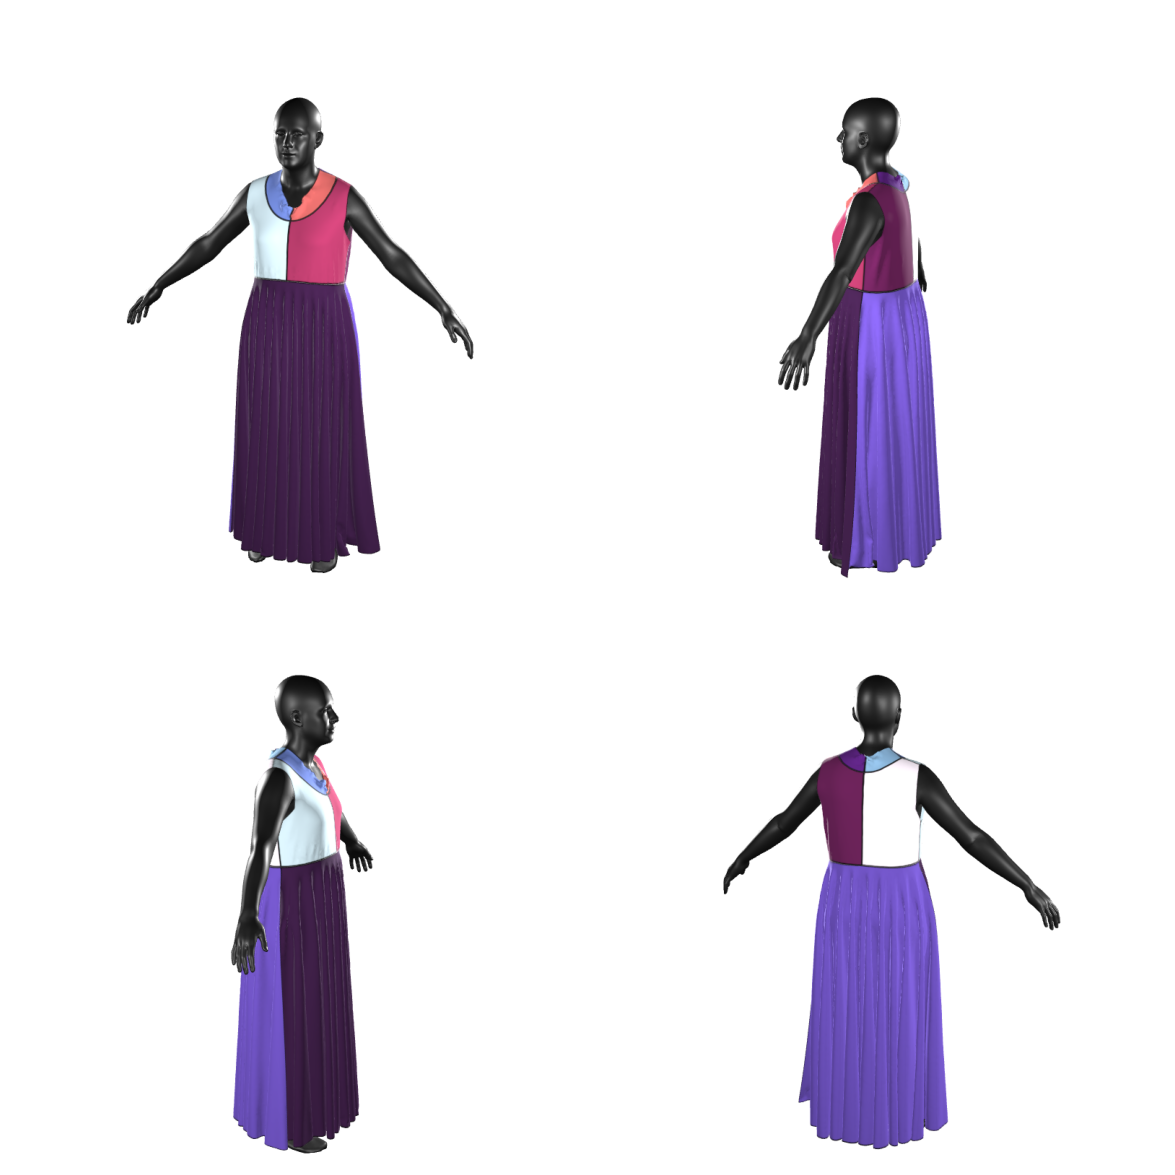

In [253]:
def create_combined_view(rendered_image_dict, projected_vertex_pose_dict, num_views=None):
    """
    Combines multiple views into a single image, preserving garment bounding boxes
    
    Args:
        rendered_image_dict: Dict of rendered images for each view
        projected_vertex_pose_dict: Dict of vertex projections for bounding boxes
        num_views: Number of views to combine (random 1-5 if None)
    """
    # Select random number of views if not specified
    if num_views is None:
        num_views = random.randint(1, min(5, len(rendered_image_dict)))
    
    # Randomly select views
    selected_views = random.sample(list(rendered_image_dict.keys()), num_views)
    
    # Get bounding boxes and images
    boxes = []
    images = []
    for view in selected_views:
        img = np.array(rendered_image_dict[view].convert('RGB'))
        x1, y1 = projected_vertex_pose_dict[view].min(axis=0)
        x2, y2 = projected_vertex_pose_dict[view].max(axis=0)
        boxes.append((int(x1), int(y1), int(x2), int(y2)))
        images.append(img)
    
    # Calculate layout
    if num_views <= 2:
        rows, cols = 1, num_views
    else:
        rows = 2
        cols = (num_views + 1) // 2
    
    # Calculate maximum dimensions needed for each cell
    max_width = max(img.shape[1] for img in images)
    max_height = max(img.shape[0] for img in images)
    
    # Create output image
    output = np.zeros((max_height * rows, max_width * cols, 3), dtype=np.uint8)
    
    # Place images
    for idx, (img, box) in enumerate(zip(images, boxes)):
        row = idx // cols
        col = idx % cols
        
        # Calculate position in output image
        y_offset = row * max_height
        x_offset = col * max_width
        
        # Copy image
        output[y_offset:y_offset+img.shape[0], 
               x_offset:x_offset+img.shape[1]] = img
        
    return output

# Example usage:
combined_img = create_combined_view(rendered_image_dict, projected_vertex_pose_dict)
plt.figure(figsize=(15, 15))
plt.imshow(combined_img)
plt.axis('off')
plt.show()

In [36]:
side_list = random.sample(["front", "back", "left", "right"], random.randint(1, 4))
side_list

['right', 'front']

In [ ]:
import random

# Pick 2 random values from garment_path_list
random_paths = random.sample(garment_path_list, 2)

print("Randomly selected paths:")
for path in random_paths:
    print(path)


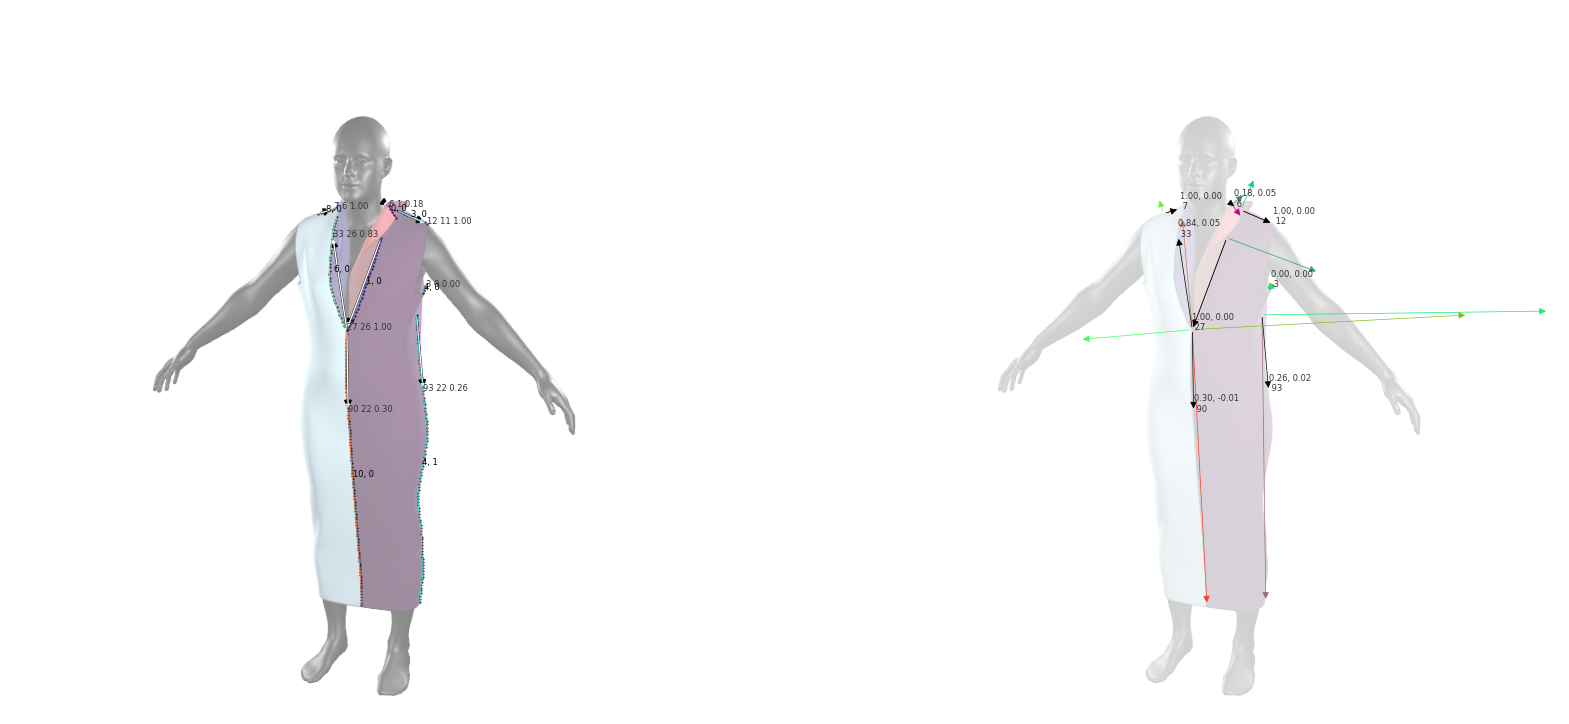

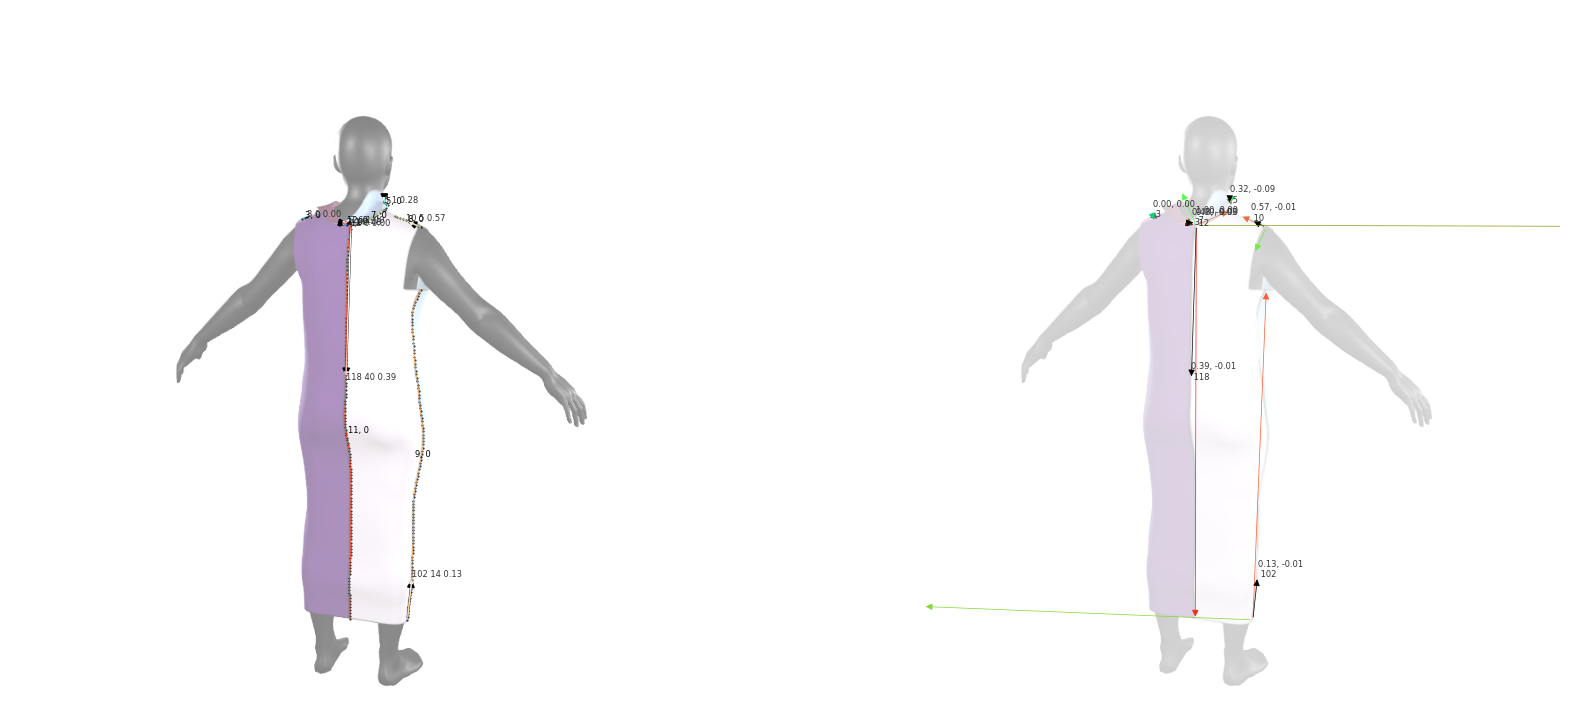

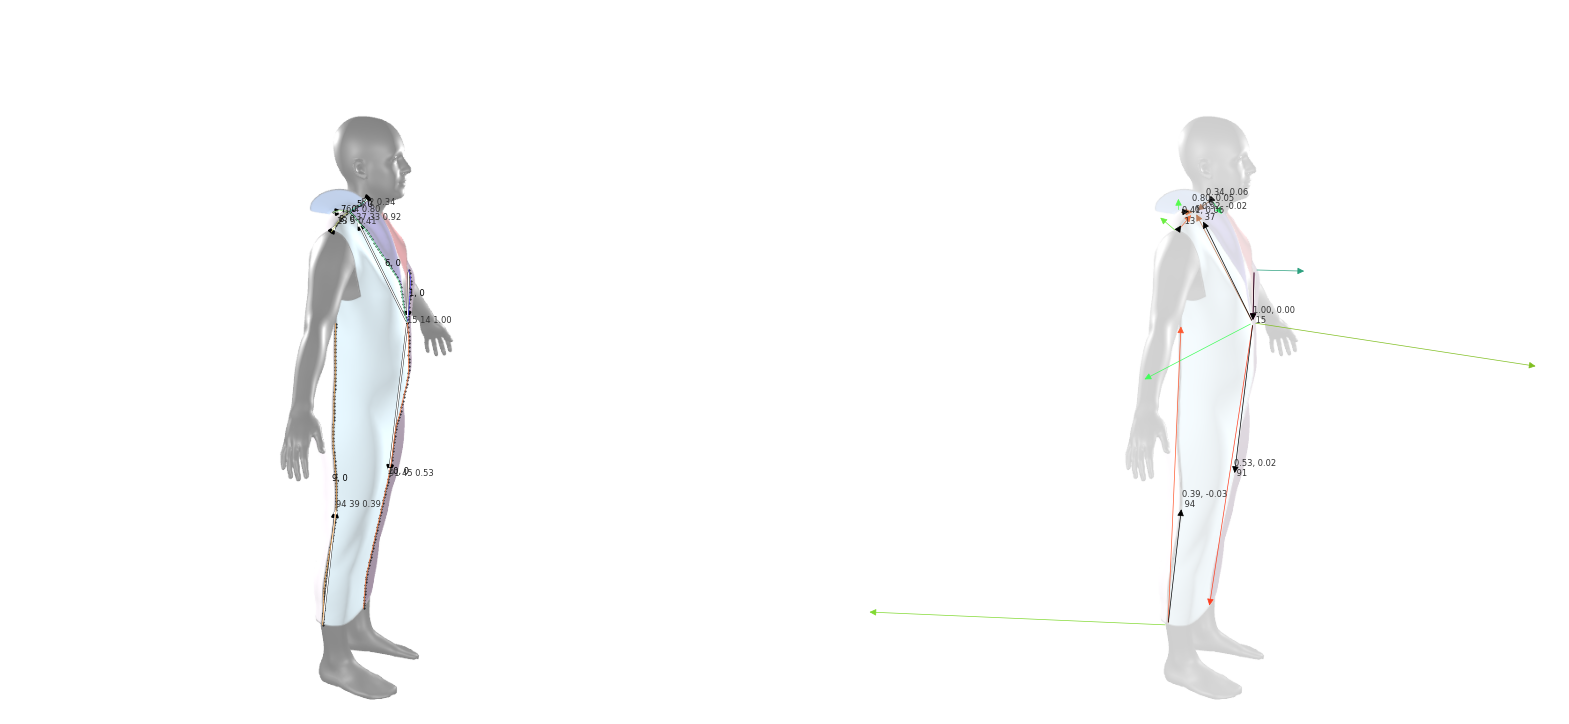

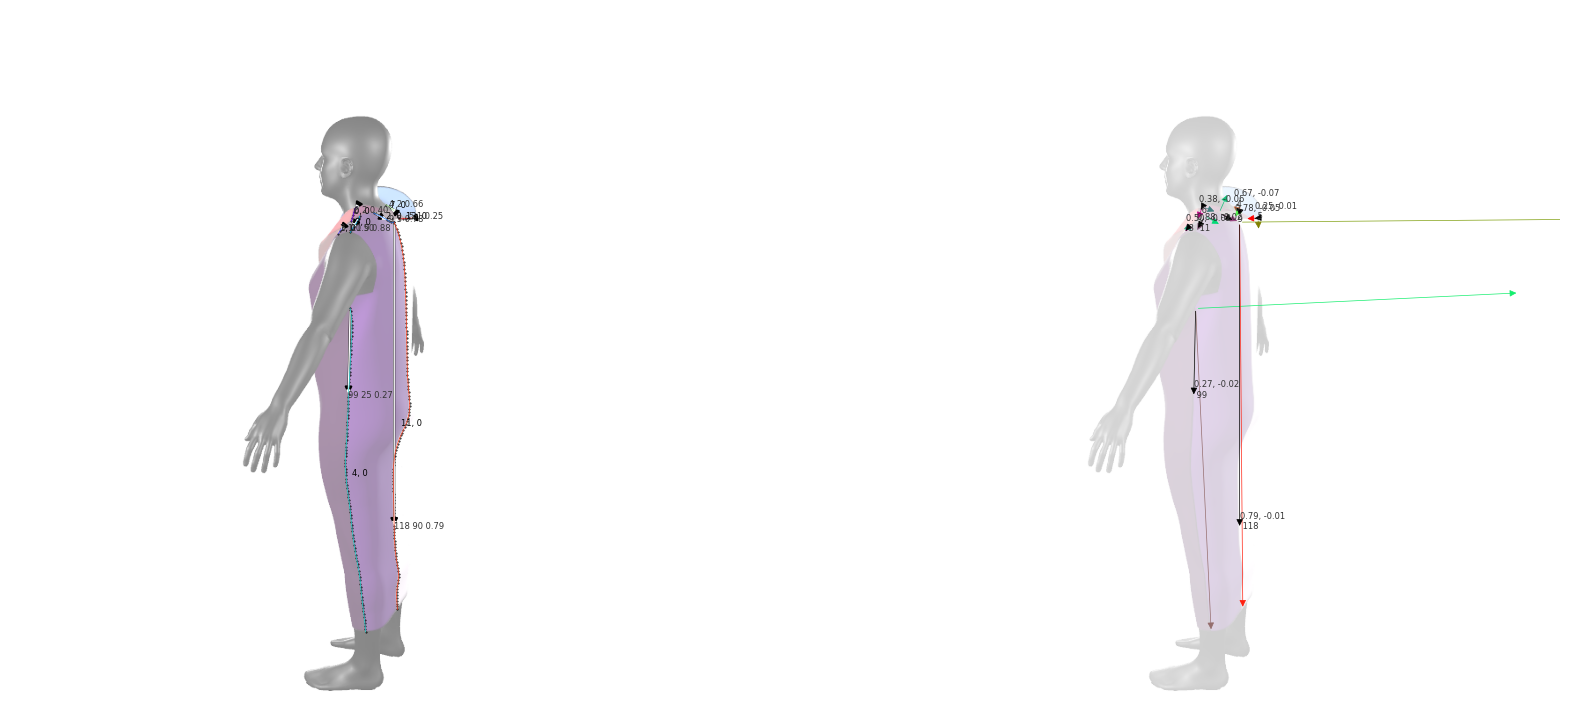

In [2]:
IDX = random.randint(0, len(garment_path_list) - 1)


garment_path = garment_path_list[IDX]
garment_id = os.path.basename(garment_path)


FIGLEN = 10
NROWS = 1
NCOLS = 2

rendered_image_dict = {}
for side in ["front", "back", "left", "right"] :
    rendered_image_dict[side] = Image.open(os.path.join(garment_path, f"rendered_{side}.png"))
    
with open(os.path.join(garment_path, f"{garment_id}_fltrd_vis_seam_line_dict.pkl"), "rb") as f :
    fltrd_vis_seam_line_dict = pickle.load(f)


STCH_IDX_MAX = max(list(map(
    lambda stch_dict : max(stch_dict.keys()),
    fltrd_vis_seam_line_dict.values()
)))
colors = plt.cm.rainbow(np.linspace(0, 1, STCH_IDX_MAX + 1))

for side in fltrd_vis_seam_line_dict.keys():
    plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN))
    ax1 = plt.subplot(1, NCOLS, 1)
    ax1.imshow(rendered_image_dict[side], alpha=0.5)
    ax1.axis("off")
    
    ax2 = plt.subplot(1, NCOLS, 2)
    ax2.imshow(rendered_image_dict[side], alpha=0.2)
    ax2.axis("off")

    for seam_idx, seam_dict in fltrd_vis_seam_line_dict[side].items():
        for segment_idx, (
            segment_idx_arr, segment_pos_arr,
            segment_edge_len_arr, segment_t_arr,
            segment_u_arr, segment_v_arr
        ) in enumerate(zip(
            seam_dict["segment_idx_arr_list"],
            seam_dict["segment_pos_arr_list"],
            seam_dict["segment_edge_len_arr_list"],
            seam_dict["segment_t_arr_list"],
            seam_dict["segment_u_arr_list"],
            seam_dict["segment_v_arr_list"]
        )):
            
            i_vec = segment_pos_arr[-1] - segment_pos_arr[0]
            j_vec = np.array([i_vec[1], -i_vec[0]])
            
            
            # print(
            #     len(segment_idx_arr), len(segment_pos_arr),
            #     len(edge_len_arr), len(t_arr),
            #     len(u_arr), len(v_arr)
            # )
            
            ax1.annotate(
                f"{seam_idx}, {segment_idx}",
                xy = (segment_pos_arr.mean(axis=0)),
                xytext = (segment_pos_arr.mean(axis=0)),
                fontsize=6
            )
            ax1.plot(
                segment_pos_arr[:, 0],
                segment_pos_arr[:, 1],
                '-',
                color=colors[seam_idx],
                linewidth=0.5
            )
            ax1.scatter(
                segment_pos_arr[:, 0],
                segment_pos_arr[:, 1],
                color="black",
                s=0.2
            )
            
            
            arrow_i = FancyArrowPatch(
                segment_pos_arr[0], segment_pos_arr[0] + i_vec,
                arrowstyle='-|>',
                mutation_scale=10,
                color=np.mean(
                    [colors[seam_idx], np.array([1, 0, 0, 1])],
                    axis=0
                ),
                linewidth=0.5
            )
            
            arrow_j = FancyArrowPatch(
                segment_pos_arr[0], segment_pos_arr[0] + j_vec,
                arrowstyle='-|>',
                mutation_scale=10,
                color=np.mean(
                    [colors[seam_idx], np.array([0, 1, 0, 1])],
                    axis=0
                ),
                linewidth=0.5
            )
            ax2.add_patch(arrow_i)
            ax2.add_patch(arrow_j)
            
            random_idx = random.randint(0, len(segment_pos_arr) - 1)
            t = segment_t_arr[random_idx]
            u = segment_u_arr[random_idx]
            v = segment_v_arr[random_idx]
            
            ax1.annotate(
                f"{len(segment_pos_arr)} {random_idx} {t:.2f}",
                xy = (segment_pos_arr[random_idx]),
                xytext = (segment_pos_arr[random_idx]),
                fontsize=6, color=(0.2, 0.2, 0.2, 1)
            )
            
            arrow_1 = FancyArrowPatch(
                segment_pos_arr[0], segment_pos_arr[random_idx],
                arrowstyle='-|>',
                mutation_scale=10,
                color='black',
                linewidth=1.5
            )
            arrow_2 = FancyArrowPatch(
                segment_pos_arr[0],
                segment_pos_arr[0] + u * i_vec + v * j_vec,
                arrowstyle='-|>',
                mutation_scale=5,
                color='white',
                linewidth=1
            )
            ax1.add_patch(arrow_1)
            ax1.add_patch(arrow_2)
            
            
            ax2.annotate(
                f"{u:.2f}, {v:.2f} \n {len(segment_t_arr)}",
                xy = (segment_pos_arr[random_idx]),
                xytext = (segment_pos_arr[random_idx]),
                fontsize=6, color=(0.2, 0.2, 0.2, 1)
            )
            
            arrow_2 = FancyArrowPatch(
                segment_pos_arr[0],
                segment_pos_arr[0] + u * i_vec + v * j_vec,
                arrowstyle='-|>',
                mutation_scale=10,
                color='black',
                linewidth=0.5
            )
            ax2.add_patch(arrow_2)

In [ ]:
import random
from time import time
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import cv2
import plotly.graph_objects as go
from PIL import Image

import torch
from torch.utils.data import Dataset


class SingleImageSeamLineDataset(Dataset) :    
    def __init__(self, garment_path_list) :
        self.garment_path_list = garment_path_list
        
        
    def __len__(self) :
        return len(self.garment_path_list)
    
    def __getitem__(self, idx) :
        garment_path = self.garment_path_list[idx]
        garment_id = os.path.basename(garment_path)
        
        with open(os.path.join(garment_path, "fltrd_vis_seam_line_dict.pkl"), "rb") as f :
            fltrd_vis_seam_line_dict = pickle.load(f)
            
        # side = random.choice(list(fltrd_vis_seam_line_dict.keys()))
        side_list = random.sample(
            list(fltrd_vis_seam_line_dict.keys()),
            len(fltrd_vis_seam_line_dict.keys())
        )
        for side in side_list :
            image = Image.open(os.path.join(
                garment_path, f"{garment_id}_render_{side}.png"
            )).convert('RGB')
            
            stch_idx_2_stch_tag_map = {}
            stch_tag_idx = 0
            
            florence_input_prototype = []
            
            
            for stch_idx in fltrd_vis_seam_line_dict[side].keys() :    
                for segment_idx, (segment_idx_list, segment_pos_list) in enumerate(zip(
                    fltrd_vis_seam_line_dict[side][stch_idx]["segment_idx_list"],
                    fltrd_vis_seam_line_dict[side][stch_idx]["segment_pos_list"]
                )) :
                    if len(segment_pos_list) > 0 :                    
                        if stch_idx not in stch_idx_2_stch_tag_map.keys() :
                            stch_idx_2_stch_tag_map[stch_idx] = stch_tag_idx
                            stch_tag_idx += 1
                        florence_input_prototype.append(
                            f"<stitch_{stch_idx_2_stch_tag_map[stch_idx]}>"
                        )
                        
                        florence_input_prototype.extend(
                            [
                                *list(map(
                                    lambda x : f"<loc_{x}>",
                                    (
                                        np.array(segment_pos_list) / 8 * 10
                                    ).astype(int).flatten().tolist()
                                ))
                            ]
                        )
            if len(florence_input_prototype) < 1024 :
                return "<PatternRecon>", "".join(florence_input_prototype), image
    
        print("output length exceed 1024")    
        return "<PatternRecon>", "".join(florence_input_prototype), image
    